## The Moist Adiabat

This script computes the moist adiabat for an atmosphere
which is a mixture of a noncondensing and a condensing
component.  It also computes the vertical profile of
the mass specific concentration of the condensible
component, and plots the results. 

This notebook explains how the calculation is done, and makes it easy to explore and experiment with the structure of the calculation. For easier use as parts of other calculations, a version of the MoistAdiabat function, implemented as a callable object, is included in the phys.py module. 


In [1]:
#Data on section of text which this script is associated with
Chapter = '2.**'
Figure = '**'

In [2]:
#Insert __from__future imports for backwards compatibility with Python 2.7
import phys
from ClimateUtilities import *
from math import *

In [3]:
#Dry and one-component adiabat functions, for comparison
#Note that the use of Numeric.log lets this take
#an array as an argument for p. The rest of the arithmetic,
#including the exponentiation in the dry adiabat, works
#equally well for a Numeric array as for a regular number
#
#**ToDo: Note that the formula for Tdry uses R/cp for dry air for
#comparison. This is what was used in the first edition
#of the Principles of Planetary Climate. However for high
#temperatures, the condensible concentration alters the
#value of R/cp, so it would be more appropriate to use the value
#of R/cp based on the actual mix of condensible and noncondensible.
#This may not matter much, though, since the main point of the comparison
#is to show the convergence to the dry adiabat at low temperatures.
def Tsat(p):
    return(1./(1./Tr - (Rc/L)*numpy.log(p/psat_ref)))
def Tdry(Ts,p):
    return Ts*(p/p[0])**(Ra/cpa)

#**ToDo: Add controls on resolution, top of atmosphere, etc. (only needed for object version in phys.py)
#**ToDo: Change notation from q to r for mixing ratio
#**ToDo: satvps_function switches to L for ice when below triple point, but L specified in
# moist adiabat formula is always vaporization.  For consistency, should either put in a switch
# for L in the slope function, or use satvps for liquid alone.  Provisionally, the saturation vapour
#pressure function has been forced to use the liquid value even below the triple point.
def MoistAdiabat(ps,Ts,condensible=phys.H2O,noncondensible = phys.air):
    #Set up saturation vapor pressure function
    satvp = phys.satvps_function(condensible,'liquid')#phys.satvps_function(condensible) -- Changed for 2d ed.
    #Set up thermodynamic constants
    eps = condensible.MolecularWeight/noncondensible.MolecularWeight
    L = condensible.L_vaporization
    Ra = noncondensible.R
    Rc = condensible.R
    cpa = noncondensible.cp
    cpc = condensible.cp
    #
    #Set up derivative function for integrator
    def slope(logpa,logT):
        pa = exp(logpa)
        T = exp(logT)
        rsat = eps*(satvp(T)/pa) #mixing ratio
        num = (1. + (L/(Ra*T))*rsat)*Ra
        den = cpa + (cpc + (L/(Rc*T) - 1.)*(L/T))*rsat
        return num/den
    #Initial conditions
    step = -.01  #Step size for integration
    ptop = 100. #Where to stop integration
    #
    #
    logpa = log(ps)
    logT = log(Ts)
    ad = integrator(slope,logpa,logT,step )

    #Initialize lists to save results
    pL = [exp(logpa) + satvp(exp(logT))]
    molarConL = [satvp(exp(logT))/pL[0]]
    TL = [exp(logT)]
    #Integration loop
    p = 1.e30 #Dummy initial value, to get started
    while p > ptop:
            ans = ad.next()
            pa = exp(ans[0])
            T = exp(ans[1])
            p = pa+satvp(T)
            pL.append(p)
            molarConL.append(satvp(T)/p)
            TL.append(T)
    pL = numpy.array(pL)
    TL = numpy.array(TL)
    molarConL = numpy.array(molarConL)
    #Compute the mass specific concentration
    Mc = condensible.MolecularWeight
    Mnc = noncondensible.MolecularWeight
    Mbar = molarConL*Mc +(1.-molarConL)*Mnc
    qL = (Mc/Mbar)*molarConL     
    return pL,TL,molarConL,qL

In [4]:
#Choose your mix of gases here
condensible = phys.H2O
noncon = phys.air


#Thermodynamic constants (needed for dry adiabat
#and one-component saturated adiabat computations)
L = condensible.L_vaporization
Ra = noncon.R
Rc = condensible.R
cpa = noncon.cp
Tr = condensible.TriplePointT
psat_ref = condensible.TriplePointP

<IPython.core.display.Javascript object>


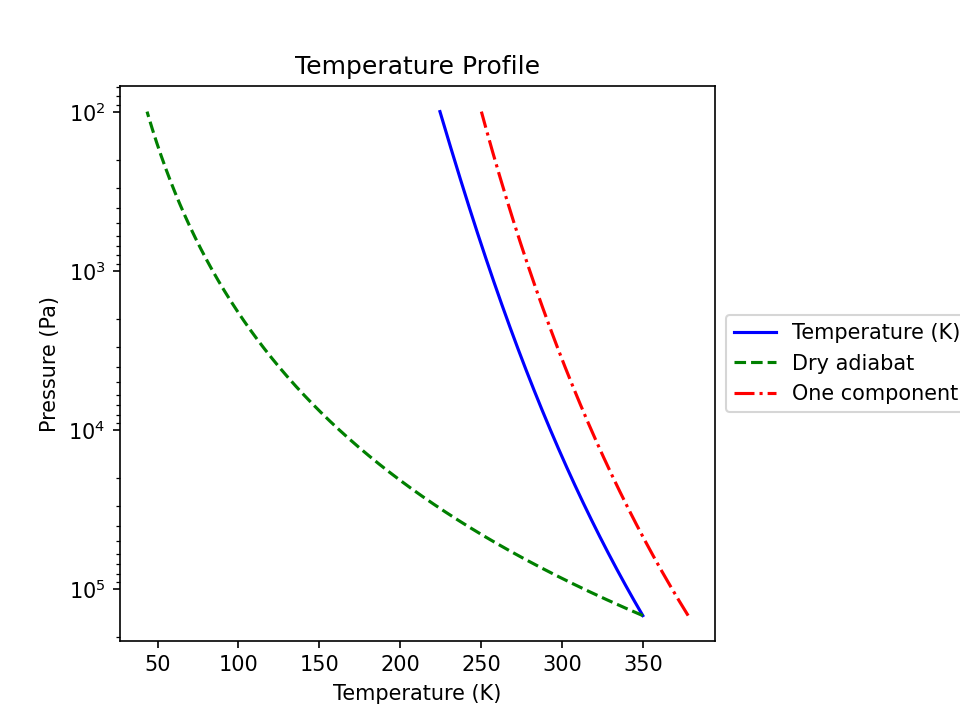

C:\Users\grahamr\Documents\GitHub\soc-rad-conv\ClimateGraphicsMPL.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = pl.subplot(111)


<IPython.core.display.Javascript object>


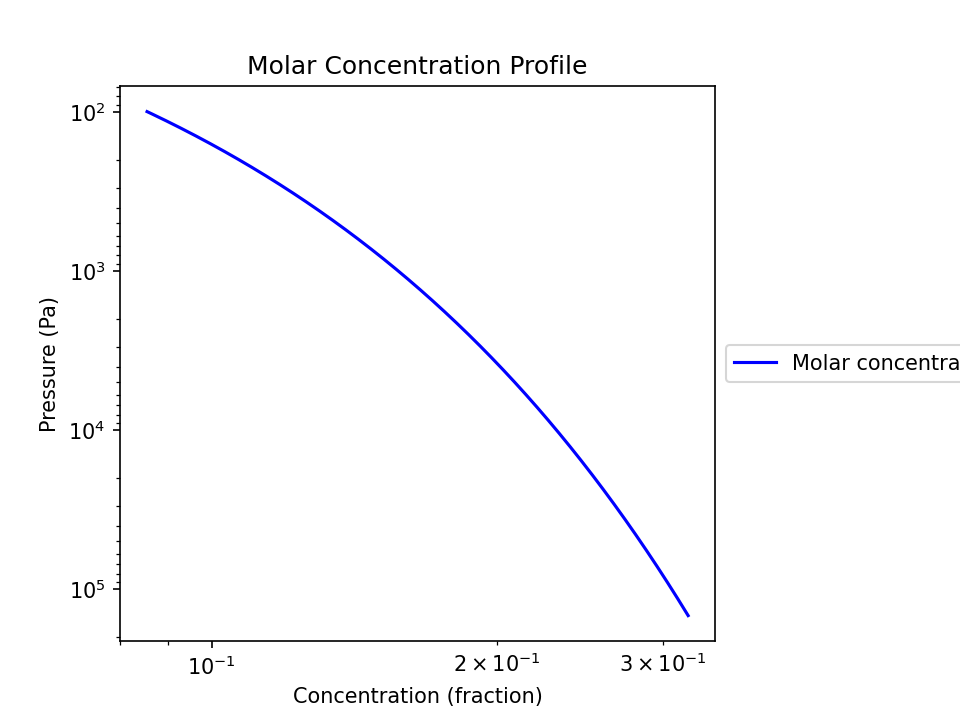

C:\Users\grahamr\Documents\GitHub\soc-rad-conv\ClimateGraphicsMPL.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = pl.subplot(111)


<IPython.core.display.Javascript object>


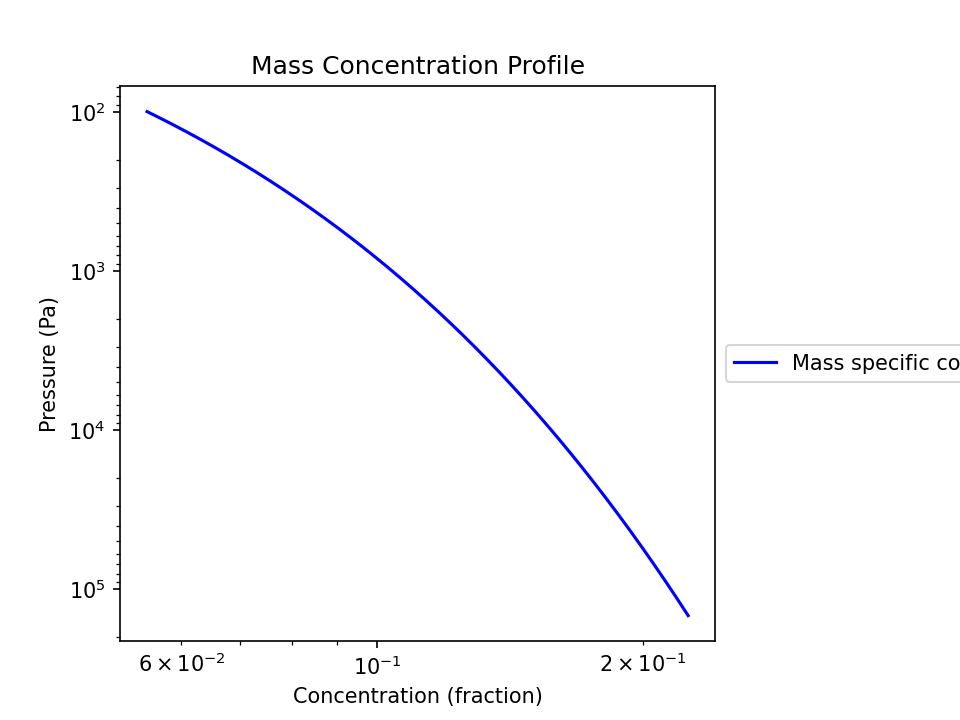

C:\Users\grahamr\Documents\GitHub\soc-rad-conv\ClimateGraphicsMPL.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = pl.subplot(111)


In [7]:
%matplotlib notebook
ps = 1.e5
Ts = 350.
p,T,molarCon,q = MoistAdiabat(ps,Ts,condensible,noncon)

#Plot temperature
c = Curve()
c.addCurve(p,'p','Pressure (Pa)')
c.addCurve(T,'T','Temperature (K)')
c.addCurve(Tdry(Ts,p),'Tdry','Dry adiabat')
c.addCurve(Tsat(p),'Tad1','One component adiabat')
c.switchXY = c.reverseY = c.YlogAxis = True
c.PlotTitle = "Temperature Profile"
c.Ylabel = "Temperature (K)"
c.Xlabel = "Pressure (Pa)"
plot(c)

#Plot Molar Concentration
c1 = Curve()
c1.switchXY = c1.reverseY = c1.YlogAxis = c1.XlogAxis = True
c1.addCurve(p,'p','Pressure (Pa)')
c1.addCurve(molarCon+1.e-30,'molarCon','Molar concentration of condensible')
c1.PlotTitle = "Molar Concentration Profile"
c1.Ylabel = "Concentration (fraction)"
c1.Xlabel = "Pressure (Pa)"
plot(c1)

#Plot Mass Concentration
c2 = Curve()
c2.switchXY = c2.reverseY = c2.YlogAxis = c2.XlogAxis = True
c2.addCurve(p,'p','Pressure (Pa)')
c2.addCurve(q+1.e-30,'q','Mass specific concentration of condensible')
c2.PlotTitle = "Mass Concentration Profile"
c2.Ylabel = "Concentration (fraction)"
c2.Xlabel = "Pressure (Pa)"
plot(c2)



        
        

### Use of the callable object implementation

Since many calculations require the computation of a moist adiabat, an implementation of the calculation has been provided in the phys.py module.  The calculation is implemented as a "callable object," which works much like a function, but has the advantage of offering more versatility in terms of configuring various options in the calculation. More properly speaking, phys.MoistAdiabat is a class, and an instance of the class is a callable object which performs the calculation of a moist adiabat.    The following illustrates the use of this implementation, which is available to any script after importing the phys.py module (done by writing: import phys). To get more information on the use of the object, type 

help(phys.MoistAdiabat)

**ToDo:  phys.MoistAdiabat needs to be modified to either use L_vaporization regardless of T, or to switch L in the moist adiabat calculation to ice or liquid according to T.  Ideally it should be extended to allow a more general specification of L(T) and the saturation vapour pressure function, allowing the defaults to be over-ridden. 

In [6]:
condensible = phys.H2O
noncondensible = phys.air
m = phys.MoistAdiabat(condensible,noncondensible)
pNonConSurf = 1.e5
Tsurf = 350.
p,T,molarCon,massCon = m(pNonConSurf,Tsurf)

c = Curve()
c.addCurve(p)
c.addCurve(T)
c.switchXY = True
c.YlogAxis = True
c.reverseY = True
plot(c)

c1 = Curve()
c1.addCurve(p)
c1.addCurve(molarCon)
c1.switchXY = True
c1.YlogAxis = True
c1.XlogAxis = True
c1.reverseY = True
plot(c1)

TypeError: __call__() missing 1 required positional argument: 'ptop'

**Note that if we specify the partial pressure of the noncondensible at the surface, the net mass of noncondensible in the atmosphere varies as we change the temperature. Put in some code here to illustrate that, and show use of an iteration to keep noncondensible mass (the noncondensible inventory) constant.